In [1]:
import torch
import matplotlib.pyplot as plt

from src.modules import HSIClassifierModule
from src.data_modules import HSIDermoscopyDataModule
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyTask

# 🔹 Path to the best checkpoint
ckpt_path = "/home/aline/Mestrado/GenAI/dgm-2025.2/projects/hyperskin/logs/hypersynth/xge5y5oy/checkpoints/epoch=04-val_acc=0.6000.ckpt"

# 🔹 Load the trained model
model = HSIClassifierModule.load_from_checkpoint(ckpt_path)
model.eval()

# 🔹 Put model on GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)




/home/aline/miniforge3/envs/hyperskin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HSIClassifierModule(
  (net): TIMMModel(
    (model): ResNet(
      (conv1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv

In [2]:
import yaml

with open("/home/aline/Mestrado/GenAI/dgm-2025.2/projects/hyperskin/logs/hypersynth/xge5y5oy/config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

transforms_cfg = cfg["data"]["init_args"]["transforms"]

dm = HSIDermoscopyDataModule(
    task=HSIDermoscopyTask.CLASSIFICATION_MELANOMA_VS_DYSPLASTIC_NEVI,
    train_val_test_split=(0.7, 0.15, 0.15),
    batch_size=1,
    num_workers=0,
    pin_memory=True,
    data_dir="data/hsi_dermoscopy",
    image_size=224,
    transforms=transforms_cfg  
)



/home/aline/miniforge3/envs/hyperskin/lib/python3.10/site-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
dm.prepare_data()
dm.setup("test")
test_loader = dm.test_dataloader()

{0: 'melanoma', 1: 'dysplastic_nevi'}


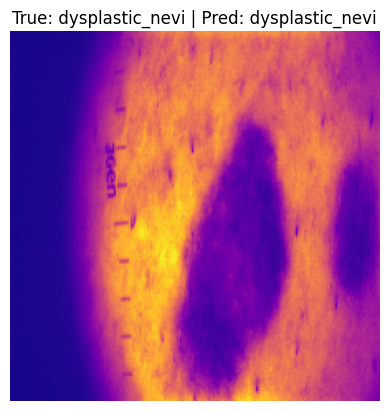

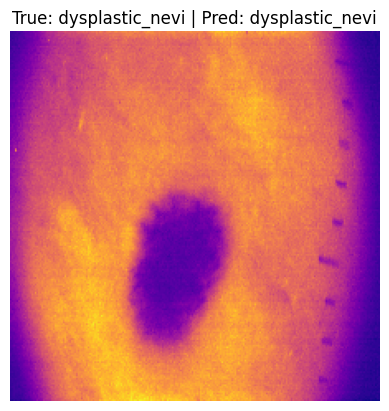

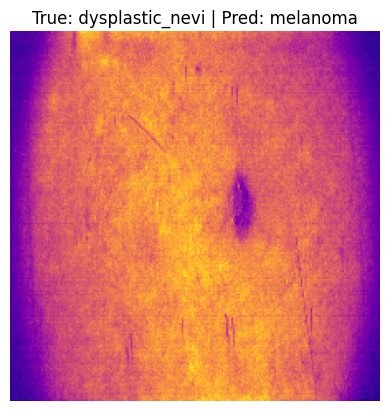

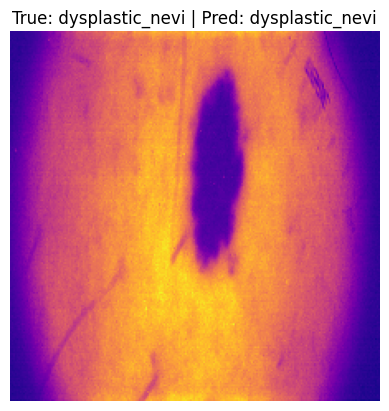

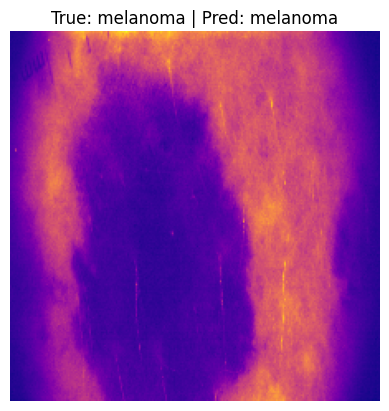

In [4]:

dataset = dm.data_test.dataset
class_names = {v: k for k, v in dataset.labels_map.items()}
print(class_names)

for i, (x, y) in enumerate(test_loader):
    if i == 5: 
        break

    x, y = x.to(device), y.to(device)

    with torch.no_grad():
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
    img = x[0].cpu()
    plt.imshow(img[4], cmap = "plasma")
    plt.title(f"True: {class_names[y.item()]} | Pred: {class_names[preds.item()]}")
    plt.axis("off")
    plt.show()

Confusion Matrix:
 [[ 3 10]
 [ 8 20]]


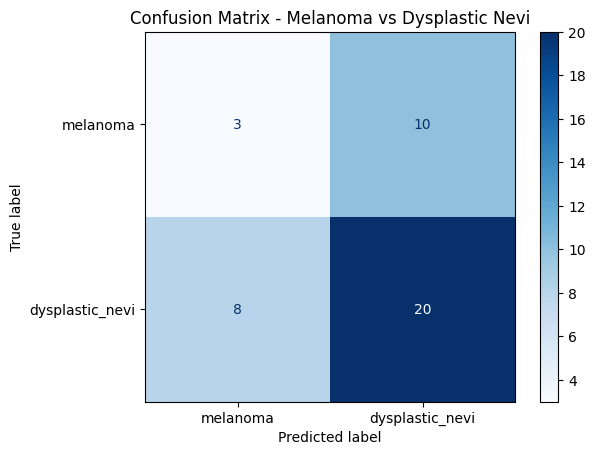

In [5]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔹 Prepare containers
all_preds = []
all_labels = []

# 🔹 Loop over test set
for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    with torch.no_grad():
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(y.cpu().numpy())

# 🔹 Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
print("Confusion Matrix:\n", cm)

# 🔹 Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["melanoma", "dysplastic_nevi"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Melanoma vs Dysplastic Nevi")
plt.show()
